In [1]:
import cv2
import glob
import imageio
import os
import PIL
import random
import time

import matplotlib.pyplot as plt
import matplotlib.animation as animate
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from IPython import display

state = 37
np.random.seed(state)
tf.random.set_seed(state)
random.seed(state)

In [2]:
print("Using GPU? {0}".format(tf.test.gpu_device_name() == "/device:GPU:0"))

Using GPU? True


# Unown-GAN
Describe project aim and motivation

## Data Handling
...

In [3]:
class PkData():
    def __init__(self, path, target="*"):
        self.sprite_files = glob.glob("{0}/{1}.png".format(path, target))
        self.shiny_files = glob.glob("{0}/shiny/{1}.png".format(path, target))
        self.all_files = list(self.sprite_files) + list(self.shiny_files)
        self.load()
        
    def load(self):
        sprites = []
        random.shuffle(self.all_files)
        for file in self.all_files:
            img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
            if img is not None:
                mask = img[:,:,3] == 0
                img[mask] = [255, 255, 255, 255]
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
                sprites.append(img)
        self.data = (np.array(sprites).astype("float") - 127.5) / 127.5
    
    def __iter__(self):
        for batch in self.data:
            yield batch
            
    def __getitem__(self, item):
        return self.data[item]
    
    def __len__(self):
        return self.data.shape[0]
    
    def random_batch(self, n=1):
        return self.data[np.random()]
    
    def to_batches(sef, batch=32):
        pass
    
    def to_rbatches(self, c, batch=32):
        self.repeated = True
        n = c//self.data.shape[0]
        data = np.repeat(np.array(self.data)[np.newaxis,:,:,:], n, axis=0)
        data = np.reshape(data, (-1, 80, 80, 3))
        np.random.shuffle(data)
        data = data[np.arange((data.shape[0] // batch) * batch)]
        self.data = np.reshape(data, (-1, batch, 80, 80, 3))
        
    def show_files(self, r=5, c=5):
        fig = plt.figure(figsize=[10,10])
        for i in range(r*c):
            ax = fig.add_subplot(r,c,i+1)
            if self.repeated:
                ax.imshow(0.5 * self.data[0][i] + 0.5)
            else:
                ax.imshow(0.5 * self.data[i] + 0.5)
            ax.set_aspect("equal")
            ax.axis(False)
        fig.subplots_adjust(wspace=0, hspace=0)

...

In [4]:
BATCH=128

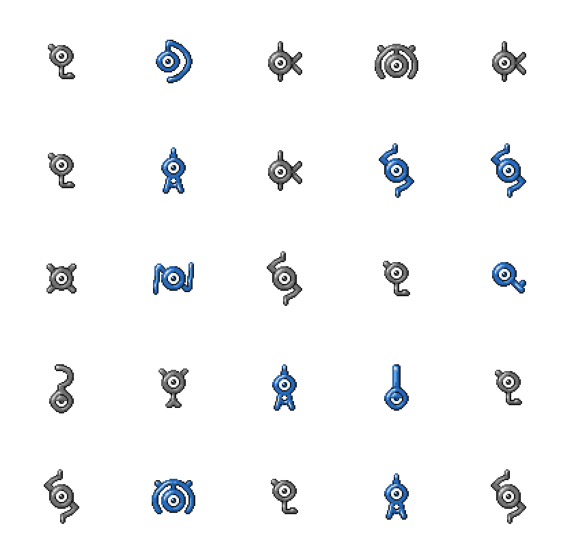

In [5]:
data = PkData("../Data/Pokemon/G4PSprites", "201*")
data.to_rbatches(30000, BATCH)
data.show_files()

## Deep-Convolutional Generative Adversarial Networks (DCGAN)
Brief description of model, how it works, architecture, etc

In [6]:
class DCGAN():
    def __init__(self, noise=128, batch=64, dropout=0.5):
        self.noise_dim = noise
        self.dropout = dropout
        self.batch_size = batch
        self.build_generator()
        self.build_discriminator()
        
        self.discriminator.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                                  optimizer=tf.keras.optimizers.RMSprop(5e-5), 
                                   metrics=["accuracy"])
        
        noise_input = keras.Input(shape=(self.noise_dim,))
        gen_img = self.generator(noise_input)
        self.discriminator.trainable = False
        dis_out = self.discriminator(gen_img)
        self.combined = keras.Model(noise_input, dis_out)
        self.combined.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                              optimizer=tf.keras.optimizers.RMSprop(5e-4))
    
    def build_generator(self):
        inputs = keras.Input(shape=(self.noise_dim,))
        x = layers.Dense(5*5*512)(inputs)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Reshape((5,5,512))(x)
        assert tuple(x.shape) == (None, 5, 5, 512)
        
        x = layers.Conv2DTranspose(256, 4, strides=1, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization(momentum=0.8)(x)
        x = layers.LeakyReLU(0.2)(x)
        assert tuple(x.shape) == (None, 5, 5, 256)
        
        x = layers.Conv2DTranspose(128, 4, strides=2, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization(momentum=0.8)(x)
        x = layers.LeakyReLU(0.2)(x)
        assert tuple(x.shape) == (None, 10, 10, 128)
        
        x = layers.Conv2DTranspose(64, 4, strides=2, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization(momentum=0.8)(x)
        x = layers.LeakyReLU(0.2)(x)
        assert tuple(x.shape) == (None, 20, 20, 64)
        
        x = layers.Conv2DTranspose(32, 4, strides=2, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization(momentum=0.8)(x)
        x = layers.LeakyReLU(0.2)(x)
        assert tuple(x.shape) == (None, 40, 40, 32)
        
        output = layers.Conv2DTranspose(3, 4, strides=2, padding="same", use_bias=False, activation="tanh")(x)
        assert tuple(output.shape) == (None, 80, 80, 3)
        
        self.generator = keras.Model(inputs=inputs, outputs=output, name="gan_generator")
    
    def build_discriminator(self):
        inputs = keras.Input(shape=(80, 80, 3))
        x = layers.Conv2D(64, 4, padding="same")(inputs)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.SpatialDropout2D(self.dropout)(x)
        
        x = layers.Conv2D(128, 4, strides=2, padding="same")(x)
        x = layers.BatchNormalization(momentum=0.8)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.SpatialDropout2D(self.dropout)(x)
        
        x = layers.Conv2D(256, 4, strides=2, padding="same")(x)
        x = layers.BatchNormalization(momentum=0.8)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.SpatialDropout2D(self.dropout)(x)
        
        x = layers.Flatten()(x)

        output = layers.Dense(1, activation="sigmoid")(x)
        
        self.discriminator = keras.Model(inputs=inputs, outputs=output, name="gan_discriminator")
    
    def summary(self):
        self.generator.summary()
        self.discriminator.summary()
    
    def show_seed(self):
        if not hasattr(self, "seed"):
            self.seed = tf.random.normal([25, self.noise_dim])
        gen_images = self.generator.predict(self.seed)
        fig = plt.figure(figsize=[10,10])
        fig.subplots_adjust(hspace=0, wspace=0)
        for i in range(25):
            ax = fig.add_subplot(5,5,i+1)
            ax.imshow(0.5 * gen_images[i] + 0.5)
            ax.axis(False)
            ax.set_aspect("equal")
        plt.show()
    
    def show_random(self):
        noise = tf.random.normal([1, self.noise_dim])
        fake = self.generator.predict(noise)
        plt.imshow(0.5 * fake[0] + 0.5)
    
    def train(self, data, epochs, img_freq=1):
        real = np.zeros((self.batch_size, 1))
        fake = np.ones((self.batch_size, 1))
        
        for epoch in range(epochs):
            batch = data[np.random.randint(0, len(data))]
            noise = tf.random.normal([self.batch_size, self.noise_dim])
            gen_images = self.generator.predict(noise)
            
            dloss_r = self.discriminator.train_on_batch(batch, real)
            dloss_f = self.discriminator.train_on_batch(gen_images, fake)
            dloss = 0.5 * (dloss_r[0] + dloss_f[0])
            gloss = self.combined.train_on_batch(noise, real)
           
            if (epoch + 1) % img_freq == 0:
                display.clear_output(wait=True)
                print("Epoch {0}".format(epoch+1))
                print("Discriminator Loss: {0}, Generator Loss: {1}".format(dloss, gloss))
                print("Real Loss: {0}, Fake Loss: {1}".format(dloss_r[0], dloss_f[0]))
                print("Real Acc: {0}, Fake Acc: {1}".format(dloss_r[1], dloss_f[1]))
                self.show_seed()

...

In [7]:
gan = DCGAN(noise=32, dropout=0.5, batch=BATCH)
gan.summary()

Model: "gan_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 12800)             422400    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12800)             0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         2097152   
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 256)       

Describe mode collapse issue

Epoch 1000
Discriminator Loss: 1.0866559743881226, Generator Loss: 2.7482547760009766
Real Loss: 1.0822479724884033, Fake Loss: 1.0910639762878418
Real Acc: 0.46875, Fake Acc: 0.3984375


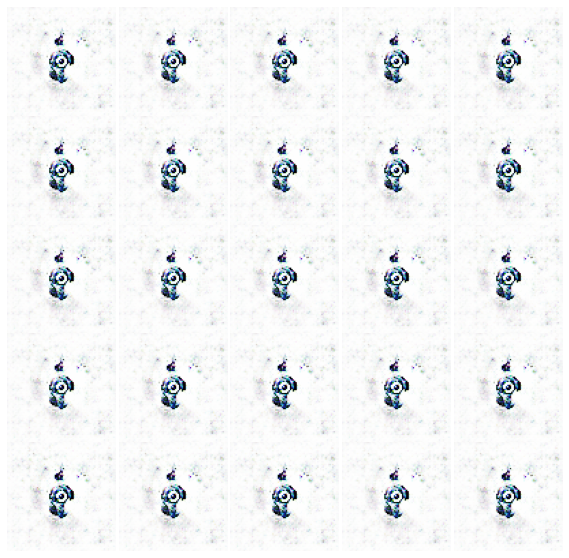

In [8]:
gan.train(data, 1000, img_freq=25)

...

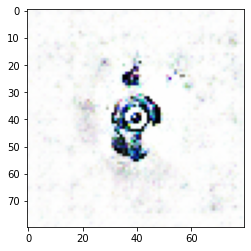

In [9]:
gan.show_random()

## Wasserstein Generative Adversarial Networks (WGAN)
Describe change of loss function, how it helps prevent mode collapse, etc

In [8]:
class WGAN(DCGAN):
    def __init__(self, noise=128, batch=64, dropout=0.5, n_dis=5):
        self.noise_dim = noise
        self.dropout = dropout
        self.batch_size = batch
        self.n_dis = n_dis
        self.build_generator()
        self.build_discriminator()
        
        self.discriminator.compile(loss=self.wloss,
                                  optimizer=tf.keras.optimizers.RMSprop(5e-4), 
                                   metrics=["accuracy"])
        
        noise_input = keras.Input(shape=(self.noise_dim,))
        gen_img = self.generator(noise_input)
        self.discriminator.trainable = False
        dis_out = self.discriminator(gen_img)
        self.combined = keras.Model(noise_input, dis_out)
        self.combined.compile(loss=self.wloss,
                              optimizer=tf.keras.optimizers.RMSprop(5e-4))
    
    def wloss(self, true, pred):
        return K.mean(true * pred)
    
    def train(self, data, epochs, img_freq=1):
        real = np.ones((self.batch_size, 1))
        fake = -np.ones((self.batch_size, 1))
        
        for epoch in range(epochs):
            for _ in range(self.n_dis):
                batch = data[np.random.randint(0, len(data))]
                noise = tf.random.normal([self.batch_size, self.noise_dim])
                gen_images = self.generator.predict(noise)

                dloss_r = self.discriminator.train_on_batch(batch, real)
                dloss_f = self.discriminator.train_on_batch(gen_images, fake)
                dloss = 0.5 * (dloss_r[0] + dloss_f[0])

                for l in self.discriminator.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -0.01, 0.01) for w in weights]
                    l.set_weights(weights)
            
            gloss = self.combined.train_on_batch(noise, real)
           
            if (epoch + 1) % img_freq == 0:
                display.clear_output(wait=True)
                print("Epoch {0}".format(epoch+1))
                print("Discriminator Loss: {0}, Generator Loss: {1}".format(1-dloss, 1-gloss))
                print("Real Loss: {0}, Fake Loss: {1}".format(1-dloss_r[0], 1-dloss_f[0]))
                self.show_seed()

...

In [ ]:
wgan = WGAN(noise=32, dropout=0.5, batch=BATCH, n_dis=5)

Describe variance of output

Epoch 1000
Discriminator Loss: 1.0005046129226685, Generator Loss: 0.4975241422653198
Real Loss: 0.5020917057991028, Fake Loss: 1.4989175200462341


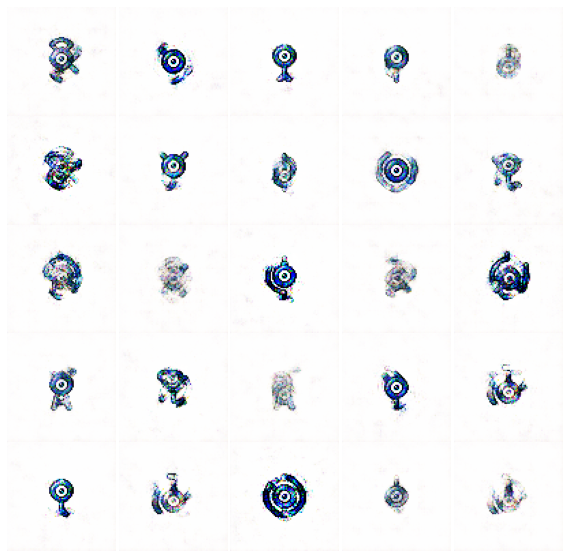

In [10]:
wgan.train(data, 1000, img_freq=25)

...

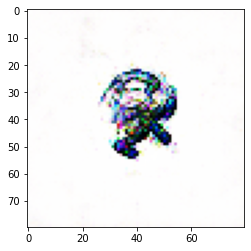

In [11]:
wgan.show_random()

...

In [14]:
wgan.generator.save_weights("gen_weights.h5")
wgan.discriminator.save_weights("dis_weights.h5")

## Exploring the Latent Space
Describe the fun stuff, visualising the linear interpolation of various model outputs

In [12]:
def interpolate(start, end, steps=5):
    percents = np.linspace(0, 1, num=steps)
    i_noise = []
    for p in percents:
        i_noise.append(((1.0 - p) * start) + (p * end))
    return np.asarray(i_noise).reshape((steps, start.shape[1]))

...

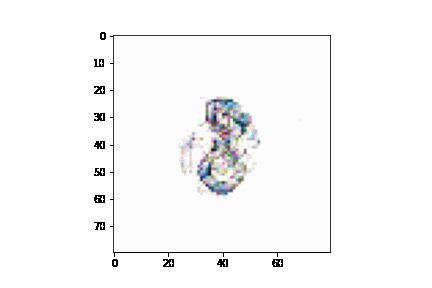

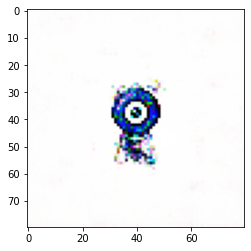

In [13]:
noise_s = tf.random.normal([1, wgan.noise_dim])
noise_e = tf.random.normal([1, wgan.noise_dim])

steps = 100
inter_noise = interpolate(noise_s, noise_e, steps)
inter_noise.shape

ims = []
images = 0.5 * wgan.generator.predict(inter_noise) + 0.5
fig = plt.figure()
for i in range(steps):
    im = plt.imshow(images[i])
    ims.append([im])
ani = animate.ArtistAnimation(fig, ims, interval=50, blit=True)
ani.save("interpolate.gif", writer="pillow")

display.Image(filename="interpolate.gif")

## Limitations & Improvements
Describe variance of dataset, old GPU, etc

## Closing Remarks
Wrap everything up, refer to the other parts of the project (API / Interface)